# Decision Tree Model Trading Results

This notebook uses a decision tree model with input variables:
 - 10s Order Flow Imbalance
 - Order Book Imbalance
 - All Volume Difference
 - The spread

And target variable as the 10s trading signal (0 = sell, 1 = do nothing, 2 = buy) to predict for every timestamp in unseen data, what the trading algorithm should do. After several tests, the spread was a big issue in attaining quality results and so additional conditions, including an inventory and a spread size condition, were implemented in the algorithm to determine whether to follow the model's recommendations (or not).

The results are below and for just one day, the algorithm generated a profit of £401.81 for the day. This is just an example and much more improvement and testing could be done. Also, should use K-fold cross-examination to test each day in turn as the test set to validate real profitability.

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ast
pd.set_option('display.max_rows', 500)

In [10]:
dates = ['2024-06-10', '2024-06-11', '2024-06-12', '2024-06-13', '2024-06-14', '2024-06-17', '2024-06-18', '2024-06-19', '2024-06-21']

In [12]:
dfs = []

In [14]:
for date in dates:
    df = pd.read_csv(f'./data/decision_tree_data/cleaned_with_signals{date}.csv')
    td = pd.to_timedelta(df['Timestamps.1'], 's')
    df = df.drop(columns=['Timestamps']).set_index(td)
    df = df.iloc[500:-500,:]
    dfs.append(df)
    display(df)

,Timestamps.1,Bids,Asks,b,a,s,m,vol_b,vol_a,dW,...,OFI20s,OFI30s,OFI45s,OFI60s,signal_5s,signal_10s,signal_20s,signal_30s,signal_45s,signal_60s
Timestamps.1,,,,,,,,,,,,,,,,,,,,,
0 days 00:00:57.412000,57.412,[[93 5]\n [91 3]\n [88 3]\n [50 1]],[[ 97 3]\n [ 98 5]\n [ 99 4]\n [100 7]...,93.0,97.0,4.0,95.0,5,3,0.0,...,-2.0,-5.0,-79.0,-96.0,1.0,1.0,1.0,1.0,2.0,2.0
0 days 00:00:57.443000,57.443,[[93 5]\n [91 3]\n [88 3]\n [50 1]],[[ 97 3]\n [ 98 5]\n [ 99 4]\n [100 7]...,93.0,97.0,4.0,95.0,5,3,0.0,...,-2.0,-5.0,-79.0,-96.0,1.0,1.0,1.0,1.0,2.0,2.0
0 days 00:00:57.567000,57.567,[[93 5]\n [91 3]\n [88 3]\n [50 1]],[[ 97 3]\n [ 98 5]\n [ 99 4]\n [100 7]...,93.0,97.0,4.0,95.0,5,3,0.0,...,-2.0,-5.0,-79.0,-96.0,1.0,1.0,1.0,1.0,2.0,2.0
0 days 00:00:57.660000,57.660,[[93 5]\n [91 3]\n [88 3]\n [50 1]],[[ 97 3]\n [ 98 5]\n [ 99 4]\n [100 7]...,93.0,97.0,4.0,95.0,5,3,0.0,...,-2.0,-6.0,-79.0,-96.0,1.0,1.0,1.0,1.0,2.0,2.0
0 days 00:00:57.691000,57.691,[[93 5]\n [91 3]\n [88 3]\n [82 1]],[[ 97 3]\n [ 98 5]\n [ 99 4]\n [100 7]...,93.0,97.0,4.0,95.0,5,3,0.0,...,-2.0,-6.0,-76.0,-96.0,1.0,1.0,1.0,1.0,2.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0 days 08:29:12.484000,30552.484,[[112 2]\n [110 4]\n [109 4]\n [108 5]...,[[115 5]\n [116 2]\n [117 2]\n [162 3]...,112.0,115.0,3.0,113.5,2,5,0.0,...,-76.0,-151.0,-125.0,-261.0,1.0,0.0,1.0,1.0,1.0,1.0
0 days 08:29:12.763000,30552.763,[[112 2]\n [110 4]\n [109 4]\n [108 5]...,[[115 5]\n [116 2]\n [117 2]\n [162 3]...,112.0,115.0,3.0,113.5,2,5,0.0,...,-74.0,-151.0,-125.0,-259.0,1.0,0.0,1.0,1.0,1.0,1.0
0 days 08:29:12.794000,30552.794,[[112 2]\n [110 4]\n [109 4]\n [108 5]...,[[114 2]\n [115 5]\n [116 2]\n [162 3]...,112.0,114.0,2.0,113.0,2,2,0.0,...,-76.0,-153.0,-127.0,-261.0,1.0,0.0,1.0,1.0,1.0,1.0


,Timestamps.1,Bids,Asks,b,a,s,m,vol_b,vol_a,dW,...,OFI20s,OFI30s,OFI45s,OFI60s,signal_5s,signal_10s,signal_20s,signal_30s,signal_45s,signal_60s
Timestamps.1,,,,,,,,,,,,,,,,,,,,,
0 days 00:00:57.939000,57.939,[[102 14]\n [ 99 7]\n [ 96 1]\n [ 89 1]...,[[107 11]\n [108 5]\n [239 4]\n [323 4]...,102.0,107.0,5.0,104.5,14,11,-2.0,...,-34.0,-59.0,-49.0,-107.0,1.0,1.0,1.0,1.0,2.0,1.0
0 days 00:00:57.970000,57.970,[[102 14]\n [ 99 7]\n [ 96 1]\n [ 89 1]...,[[107 11]\n [108 5]\n [239 4]\n [323 4]...,102.0,107.0,5.0,104.5,14,11,0.0,...,-34.0,-59.0,-49.0,-107.0,1.0,1.0,1.0,1.0,2.0,1.0
0 days 00:00:58.001000,58.001,[[106 4]\n [102 14]\n [ 99 7]\n [ 96 1]...,[[107 11]\n [108 5]\n [239 4]\n [323 4]...,106.0,107.0,1.0,106.5,4,11,4.0,...,-30.0,-55.0,-45.0,-103.0,1.0,1.0,1.0,1.0,2.0,1.0
0 days 00:00:58.094000,58.094,[[106 4]\n [102 14]\n [ 99 7]\n [ 96 1]...,[[107 11]\n [108 5]\n [176 3]\n [239 4]...,106.0,107.0,1.0,106.5,4,11,0.0,...,-30.0,-55.0,-45.0,-103.0,1.0,1.0,1.0,1.0,2.0,1.0
0 days 00:00:58.125000,58.125,[[106 4]\n [102 14]\n [ 99 7]\n [ 96 1]...,[[107 11]\n [108 5]\n [176 3]\n [239 4]...,106.0,107.0,1.0,106.5,4,11,0.0,...,-30.0,-55.0,-45.0,-103.0,1.0,1.0,1.0,1.0,2.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0 days 08:29:12.577000,30552.577,[[108 9]\n [103 1]\n [102 4]\n [ 57 3]...,[[110 3]\n [112 2]\n [116 5]\n [495 2]...,108.0,110.0,2.0,109.0,9,3,3.0,...,-202.0,-234.0,-232.0,-233.0,1.0,1.0,1.0,1.0,1.0,1.0
0 days 08:29:12.794000,30552.794,[[108 9]\n [103 1]\n [102 4]\n [ 57 3]...,[[110 3]\n [112 2]\n [116 5]\n [220 2]...,108.0,110.0,2.0,109.0,9,3,0.0,...,-205.0,-236.0,-231.0,-233.0,1.0,1.0,1.0,1.0,1.0,1.0
0 days 08:29:12.856000,30552.856,[[108 9]\n [103 1]\n [102 4]\n [ 57 3]...,[[109 3]\n [112 2]\n [116 5]\n [220 2]...,108.0,109.0,1.0,108.5,9,3,0.0,...,-208.0,-239.0,-234.0,-236.0,1.0,1.0,1.0,1.0,1.0,1.0


,Timestamps.1,Bids,Asks,b,a,s,m,vol_b,vol_a,dW,...,OFI20s,OFI30s,OFI45s,OFI60s,signal_5s,signal_10s,signal_20s,signal_30s,signal_45s,signal_60s
Timestamps.1,,,,,,,,,,,,,,,,,,,,,
0 days 00:00:49.755000,49.755,[[108 6]\n [107 11]\n [104 5]\n [102 11]...,[[119 2]\n [120 1]\n [121 2]\n [509 5]...,108.0,119.0,11.0,113.5,6,2,6.0,...,-19.0,-28.0,-54.0,-46.0,1.0,1.0,1.0,1.0,1.0,1.0
0 days 00:00:49.879000,49.879,[[108 6]\n [107 11]\n [104 5]\n [102 11]...,[[118 2]\n [120 1]\n [121 2]\n [509 5]...,108.0,118.0,10.0,113.0,6,2,0.0,...,-21.0,-30.0,-56.0,-48.0,1.0,1.0,1.0,1.0,1.0,1.0
0 days 00:00:49.910000,49.910,[[108 6]\n [107 11]\n [104 5]\n [102 11]...,[[118 2]\n [120 1]\n [121 2]\n [509 5]...,108.0,118.0,10.0,113.0,6,2,0.0,...,-21.0,-30.0,-56.0,-48.0,1.0,1.0,1.0,1.0,1.0,1.0
0 days 00:00:50.003000,50.003,[[108 6]\n [107 11]\n [104 5]\n [102 11]...,[[118 2]\n [120 1]\n [121 2]\n [339 5]...,108.0,118.0,10.0,113.0,6,2,0.0,...,-21.0,-37.0,-52.0,-48.0,1.0,1.0,1.0,1.0,1.0,1.0
0 days 00:00:50.034000,50.034,[[108 6]\n [107 11]\n [104 5]\n [102 11]...,[[118 2]\n [120 1]\n [121 2]\n [272 5]...,108.0,118.0,10.0,113.0,6,2,0.0,...,-22.0,-37.0,-52.0,-48.0,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0 days 08:29:16.080000,30556.080,[[110 3]\n [107 6]\n [106 1]\n [105 5]...,[[203 1]\n [437 1]\n [511 1]\n [536 4]...,110.0,203.0,93.0,156.5,3,1,0.0,...,-61.0,-77.0,-148.0,-213.0,1.0,1.0,1.0,1.0,1.0,1.0
0 days 08:29:16.142000,30556.142,[[110 3]\n [107 6]\n [106 1]\n [105 5]...,[[203 1]\n [437 1]\n [511 1]\n [536 4]...,110.0,203.0,93.0,156.5,3,1,0.0,...,-61.0,-77.0,-148.0,-213.0,1.0,1.0,1.0,1.0,1.0,1.0
0 days 08:29:16.235000,30556.235,[[110 3]\n [107 6]\n [106 1]\n [105 5]...,[[203 1]\n [245 1]\n [511 1]\n [536 4]...,110.0,203.0,93.0,156.5,3,1,0.0,...,-61.0,-77.0,-148.0,-213.0,1.0,1.0,1.0,1.0,1.0,1.0


,Timestamps.1,Bids,Asks,b,a,s,m,vol_b,vol_a,dW,...,OFI20s,OFI30s,OFI45s,OFI60s,signal_5s,signal_10s,signal_20s,signal_30s,signal_45s,signal_60s
Timestamps.1,,,,,,,,,,,,,,,,,,,,,
0 days 00:00:57.226000,57.226,[[106 4]\n [104 3]\n [102 1]\n [ 97 4]...,[[164 3]\n [165 1]\n [372 5]\n [677 5]...,106.0,164.0,58.0,135.0,4,3,0.0,...,18.0,20.0,28.0,115.0,1.0,1.0,1.0,1.0,1.0,1.0
0 days 00:00:57.288000,57.288,[[106 4]\n [104 3]\n [102 1]\n [ 97 4]...,[[164 3]\n [165 1]\n [197 4]\n [372 5]...,106.0,164.0,58.0,135.0,4,3,0.0,...,18.0,20.0,28.0,115.0,1.0,1.0,1.0,1.0,1.0,1.0
0 days 00:00:57.319000,57.319,[[106 4]\n [104 3]\n [102 1]\n [ 97 4]...,[[164 3]\n [197 4]\n [372 5]\n [502 1]...,106.0,164.0,58.0,135.0,4,3,0.0,...,18.0,20.0,28.0,115.0,1.0,1.0,1.0,1.0,1.0,1.0
0 days 00:00:57.412000,57.412,[[106 4]\n [104 3]\n [102 1]\n [ 97 4]...,[[164 3]\n [197 4]\n [372 5]\n [502 1]...,106.0,164.0,58.0,135.0,4,3,0.0,...,18.0,20.0,28.0,115.0,1.0,1.0,1.0,1.0,1.0,1.0
0 days 00:00:57.443000,57.443,[[106 4]\n [104 3]\n [102 1]\n [ 97 4]...,[[164 3]\n [197 4]\n [372 5]\n [502 1]...,106.0,164.0,58.0,135.0,4,3,0.0,...,19.0,20.0,28.0,115.0,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0 days 08:29:13.569000,30553.569,[[106 2]\n [104 4]\n [103 3]\n [102 10]...,[[160 2]\n [236 2]\n [473 1]\n [540 3]],106.0,160.0,54.0,133.0,2,2,0.0,...,-105.0,-153.0,-193.0,-213.0,1.0,1.0,1.0,1.0,1.0,1.0
0 days 08:29:13.600000,30553.600,[[106 2]\n [104 4]\n [103 3]\n [102 10]...,[[160 2]\n [236 2]\n [473 1]\n [540 3]],106.0,160.0,54.0,133.0,2,2,0.0,...,-102.0,-153.0,-193.0,-213.0,1.0,1.0,1.0,1.0,1.0,1.0
0 days 08:29:13.662000,30553.662,[[106 2]\n [104 4]\n [103 3]\n [102 10]...,[[160 2]\n [236 2]\n [473 1]\n [540 3]],106.0,160.0,54.0,133.0,2,2,0.0,...,-102.0,-153.0,-193.0,-213.0,1.0,1.0,1.0,1.0,1.0,1.0


,Timestamps.1,Bids,Asks,b,a,s,m,vol_b,vol_a,dW,...,OFI20s,OFI30s,OFI45s,OFI60s,signal_5s,signal_10s,signal_20s,signal_30s,signal_45s,signal_60s
Timestamps.1,,,,,,,,,,,,,,,,,,,,,
0 days 00:00:49.972000,49.972,[[108 2]\n [106 20]\n [105 4]\n [104 1]...,[[109 2]\n [155 3]\n [307 1]\n [730 2]],108.0,109.0,1.0,108.5,2,2,0.0,...,-37.0,-75.0,-58.0,-55.0,1.0,1.0,1.0,1.0,0.0,0.0
0 days 00:00:50.003000,50.003,[[108 2]\n [106 20]\n [105 4]\n [104 1]...,[[109 2]\n [307 1]\n [331 3]\n [730 2]],108.0,109.0,1.0,108.5,2,2,0.0,...,-37.0,-82.0,-58.0,-55.0,1.0,1.0,1.0,1.0,0.0,0.0
0 days 00:00:50.034000,50.034,[[108 2]\n [106 20]\n [105 4]\n [104 1]...,[[109 2]\n [307 1]\n [331 3]\n [730 2]],108.0,109.0,1.0,108.5,2,2,0.0,...,-35.0,-82.0,-58.0,-55.0,1.0,1.0,1.0,1.0,0.0,0.0
0 days 00:00:50.251000,50.251,[[108 2]\n [106 20]\n [105 4]\n [104 1]...,[[109 2]\n [307 1]\n [442 3]\n [730 2]],108.0,109.0,1.0,108.5,2,2,0.0,...,-35.0,-82.0,-58.0,-55.0,1.0,1.0,1.0,1.0,0.0,0.0
0 days 00:00:50.313000,50.313,[[108 2]\n [106 20]\n [105 4]\n [104 1]...,[[109 2]\n [307 1]\n [573 3]\n [730 2]],108.0,109.0,1.0,108.5,2,2,0.0,...,-35.0,-82.0,-58.0,-55.0,1.0,1.0,1.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0 days 08:29:10.004000,30550.004,[[107 6]\n [105 12]\n [103 1]\n [102 1]...,[[114 2]\n [115 3]\n [116 5]\n [188 2]...,107.0,114.0,7.0,110.5,6,2,0.0,...,-119.0,-230.0,-366.0,-466.0,1.0,1.0,1.0,1.0,0.0,1.0
0 days 08:29:10.035000,30550.035,[[107 6]\n [105 12]\n [103 1]\n [102 1]...,[[114 2]\n [115 3]\n [116 5]\n [264 4]...,107.0,114.0,7.0,110.5,6,2,0.0,...,-119.0,-230.0,-366.0,-466.0,1.0,1.0,1.0,1.0,0.0,1.0
0 days 08:29:10.128000,30550.128,[[107 6]\n [105 12]\n [103 1]\n [102 1]...,[[114 2]\n [115 3]\n [116 5]\n [264 4]...,107.0,114.0,7.0,110.5,6,2,0.0,...,-123.0,-229.0,-361.0,-466.0,1.0,1.0,1.0,1.0,0.0,1.0


,Timestamps.1,Bids,Asks,b,a,s,m,vol_b,vol_a,dW,...,OFI20s,OFI30s,OFI45s,OFI60s,signal_5s,signal_10s,signal_20s,signal_30s,signal_45s,signal_60s
Timestamps.1,,,,,,,,,,,,,,,,,,,,,
0 days 00:00:53.816000,53.816,[[105 1]\n [103 2]\n [102 7]\n [ 95 3]...,[[157 5]\n [160 2]\n [262 3]\n [334 4]...,105.0,157.0,52.0,131.0,1,5,0.0,...,-51.0,-14.0,-71.0,-52.0,1.0,1.0,1.0,1.0,0.0,1.0
0 days 00:00:53.847000,53.847,[[105 1]\n [103 2]\n [102 7]\n [ 95 3]...,[[157 5]\n [160 2]\n [262 3]\n [334 4]...,105.0,157.0,52.0,131.0,1,5,0.0,...,-51.0,-14.0,-71.0,-52.0,1.0,1.0,1.0,1.0,0.0,1.0
0 days 00:00:54.033000,54.033,[[105 1]\n [103 2]\n [102 7]\n [ 95 3]...,[[157 5]\n [160 2]\n [262 3]\n [398 4]...,105.0,157.0,52.0,131.0,1,5,0.0,...,-52.0,-14.0,-71.0,-52.0,1.0,1.0,1.0,1.0,0.0,1.0
0 days 00:00:54.064000,54.064,[[105 1]\n [103 2]\n [102 7]\n [101 4]...,[[157 5]\n [160 2]\n [262 3]\n [398 4]...,105.0,157.0,52.0,131.0,1,5,0.0,...,-52.0,-14.0,-71.0,-52.0,1.0,1.0,1.0,1.0,0.0,1.0
0 days 00:00:54.312000,54.312,[[102 7]\n [101 4]\n [ 95 3]\n [ 94 2]...,[[157 5]\n [160 2]\n [262 3]\n [398 4]...,102.0,157.0,55.0,129.5,7,5,-1.0,...,-53.0,-15.0,-72.0,-53.0,1.0,1.0,1.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0 days 08:29:09.322000,30549.322,[[106 7]\n [105 1]\n [104 7]\n [103 2]...,[[108 1]\n [114 1]\n [700 1]\n [795 1]],106.0,108.0,2.0,107.0,7,1,0.0,...,-98.0,-119.0,-298.0,-352.0,1.0,1.0,1.0,1.0,1.0,1.0
0 days 08:29:09.446000,30549.446,[[106 7]\n [105 1]\n [104 7]\n [103 2]...,[[107 5]\n [108 1]\n [114 1]\n [700 1]...,106.0,107.0,1.0,106.5,7,5,0.0,...,-103.0,-120.0,-303.0,-354.0,1.0,1.0,1.0,1.0,1.0,1.0
0 days 08:29:09.663000,30549.663,[[106 7]\n [105 1]\n [104 7]\n [103 2]...,[[107 5]\n [108 1]\n [114 1]\n [307 1]...,106.0,107.0,1.0,106.5,7,5,0.0,...,-106.0,-120.0,-301.0,-351.0,1.0,1.0,1.0,1.0,1.0,1.0


,Timestamps.1,Bids,Asks,b,a,s,m,vol_b,vol_a,dW,...,OFI20s,OFI30s,OFI45s,OFI60s,signal_5s,signal_10s,signal_20s,signal_30s,signal_45s,signal_60s
Timestamps.1,,,,,,,,,,,,,,,,,,,,,
0 days 00:00:57.474000,57.474,[[106 6]\n [105 2]\n [103 5]\n [101 2]...,[[312 4]\n [632 1]\n [649 3]],106.0,312.0,206.0,209.0,6,4,0.0,...,-40.0,16.0,12.0,-12.0,1.0,1.0,1.0,1.0,1.0,1.0
0 days 00:00:57.815000,57.815,[[106 5]\n [105 2]\n [103 5]\n [101 2]...,[[312 4]\n [632 1]\n [649 3]],106.0,312.0,206.0,209.0,5,4,-1.0,...,-59.0,15.0,12.0,-13.0,1.0,1.0,1.0,1.0,1.0,1.0
0 days 00:00:57.846000,57.846,[[106 5]\n [105 2]\n [103 5]\n [101 2]...,[[312 4]\n [649 3]\n [784 1]],106.0,312.0,206.0,209.0,5,4,0.0,...,-59.0,15.0,12.0,-13.0,1.0,1.0,1.0,1.0,1.0,1.0
0 days 00:00:57.908000,57.908,[[106 5]\n [105 2]\n [103 5]\n [101 2]...,[[312 4]\n [649 3]\n [784 1]],106.0,312.0,206.0,209.0,5,4,0.0,...,-61.0,15.0,12.0,-13.0,1.0,1.0,1.0,1.0,1.0,1.0
0 days 00:00:57.939000,57.939,[[106 5]\n [105 2]\n [103 5]\n [101 2]...,[[312 4]\n [649 3]\n [784 1]],106.0,312.0,206.0,209.0,5,4,0.0,...,-61.0,15.0,12.0,-13.0,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0 days 08:29:06.284000,30546.284,[[79 2]\n [78 4]\n [20 4]],[[ 95 5]\n [ 97 3]\n [101 1]\n [433 2]...,79.0,95.0,16.0,87.0,2,5,2.0,...,-23.0,-32.0,-80.0,-110.0,2.0,2.0,2.0,2.0,2.0,2.0
0 days 08:29:06.377000,30546.377,[[79 2]\n [78 4]\n [20 4]],[[ 95 5]\n [ 97 3]\n [101 1]\n [249 5]...,79.0,95.0,16.0,87.0,2,5,0.0,...,-23.0,-32.0,-80.0,-109.0,2.0,2.0,2.0,2.0,2.0,2.0
0 days 08:29:06.470000,30546.470,[[79 2]\n [20 4]\n [ 4 4]],[[ 95 5]\n [ 97 3]\n [101 1]\n [249 5]...,79.0,95.0,16.0,87.0,2,5,0.0,...,-23.0,-32.0,-83.0,-109.0,2.0,2.0,2.0,2.0,2.0,2.0


,Timestamps.1,Bids,Asks,b,a,s,m,vol_b,vol_a,dW,...,OFI20s,OFI30s,OFI45s,OFI60s,signal_5s,signal_10s,signal_20s,signal_30s,signal_45s,signal_60s
Timestamps.1,,,,,,,,,,,,,,,,,,,,,
0 days 00:00:53.134000,53.134,[[107 9]\n [106 3]\n [105 6]\n [103 13]...,[[108 3]\n [109 2]\n [222 1]\n [565 1]...,107.0,108.0,1.0,107.5,9,3,0.0,...,16.0,6.0,-5.0,-37.0,1.0,1.0,0.0,0.0,0.0,1.0
0 days 00:00:53.289000,53.289,[[107 9]\n [106 3]\n [105 6]\n [103 13]...,[[108 3]\n [109 2]\n [222 1]\n [565 1]...,107.0,108.0,1.0,107.5,9,3,0.0,...,16.0,7.0,0.0,-37.0,1.0,1.0,0.0,0.0,0.0,1.0
0 days 00:00:53.506000,53.506,[[107 9]\n [106 3]\n [105 6]\n [103 13]...,[[108 3]\n [109 2]\n [222 1]\n [565 1]...,107.0,108.0,1.0,107.5,9,3,0.0,...,20.0,7.0,5.0,-37.0,1.0,1.0,0.0,0.0,0.0,1.0
0 days 00:00:53.630000,53.630,[[107 9]\n [106 3]\n [103 13]\n [102 5]...,[[108 3]\n [109 2]\n [222 1]\n [565 1]...,107.0,108.0,1.0,107.5,9,3,0.0,...,20.0,10.0,5.0,-37.0,1.0,1.0,0.0,0.0,0.0,1.0
0 days 00:00:53.723000,53.723,[[107 9]\n [106 3]\n [103 13]\n [102 5]...,[[108 3]\n [109 2]\n [230 1]\n [565 1]...,107.0,108.0,1.0,107.5,9,3,0.0,...,20.0,10.0,5.0,-37.0,1.0,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0 days 08:29:08.020000,30548.020,[[108 1]\n [107 5]\n [105 2]\n [102 6]...,[[137 4]\n [138 2]\n [194 1]\n [370 1]...,108.0,137.0,29.0,122.5,1,4,0.0,...,-85.0,-123.0,-163.0,-254.0,1.0,1.0,1.0,1.0,1.0,1.0
0 days 08:29:08.144000,30548.144,[[108 1]\n [107 5]\n [105 2]\n [102 6]...,[[137 4]\n [138 2]\n [194 1]\n [370 1]...,108.0,137.0,29.0,122.5,1,4,0.0,...,-85.0,-123.0,-161.0,-254.0,1.0,1.0,1.0,1.0,1.0,1.0
0 days 08:29:08.330000,30548.330,[[108 1]\n [107 5]\n [105 2]\n [102 6]...,[[137 4]\n [138 2]\n [194 1]\n [490 5]...,108.0,137.0,29.0,122.5,1,4,0.0,...,-84.0,-123.0,-159.0,-250.0,1.0,1.0,1.0,1.0,1.0,1.0


,Timestamps.1,Bids,Asks,b,a,s,m,vol_b,vol_a,dW,...,OFI20s,OFI30s,OFI45s,OFI60s,signal_5s,signal_10s,signal_20s,signal_30s,signal_45s,signal_60s
Timestamps.1,,,,,,,,,,,,,,,,,,,,,
0 days 00:00:56.234000,56.234,[[101 2]\n [100 6]\n [ 97 7]\n [ 85 3]...,[[105 1]\n [106 2]\n [107 4]\n [154 1]...,101.0,105.0,4.0,103.0,2,1,0.0,...,-58.0,-82.0,-103.0,-100.0,1.0,1.0,2.0,2.0,1.0,2.0
0 days 00:00:56.358000,56.358,[[101 2]\n [100 6]\n [ 97 7]\n [ 85 3]...,[[105 1]\n [106 2]\n [107 4]\n [154 1]...,101.0,105.0,4.0,103.0,2,1,0.0,...,-58.0,-85.0,-103.0,-100.0,1.0,1.0,2.0,2.0,1.0,2.0
0 days 00:00:56.389000,56.389,[[101 2]\n [100 6]\n [ 97 7]\n [ 85 3]...,[[105 1]\n [106 2]\n [107 4]\n [154 1]...,101.0,105.0,4.0,103.0,2,1,0.0,...,-58.0,-85.0,-103.0,-100.0,1.0,1.0,2.0,2.0,1.0,2.0
0 days 00:00:56.420000,56.420,[[101 2]\n [100 6]\n [ 97 7]\n [ 85 3]...,[[104 1]\n [106 2]\n [107 4]\n [154 1]...,101.0,104.0,3.0,102.5,2,1,0.0,...,-59.0,-86.0,-104.0,-101.0,1.0,1.0,2.0,2.0,2.0,2.0
0 days 00:00:56.575000,56.575,[[101 2]\n [100 6]\n [ 97 7]\n [ 85 3]...,[[104 1]\n [106 2]\n [107 4]\n [154 1]...,101.0,104.0,3.0,102.5,2,1,0.0,...,-59.0,-86.0,-101.0,-101.0,1.0,1.0,2.0,2.0,2.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0 days 08:29:12.174000,30552.174,[[87 2]\n [86 1]\n [66 10]\n [54 2]\n [51 2]],[[ 94 1]\n [ 97 4]\n [ 99 3]\n [100 2]...,87.0,94.0,7.0,90.5,2,1,0.0,...,-128.0,-130.0,-199.0,-257.0,1.0,1.0,1.0,2.0,2.0,2.0
0 days 08:29:12.205000,30552.205,[[87 2]\n [86 1]\n [66 10]\n [54 2]\n [51 2]],[[ 94 1]\n [ 97 4]\n [ 99 3]\n [100 2]...,87.0,94.0,7.0,90.5,2,1,0.0,...,-125.0,-130.0,-199.0,-257.0,1.0,1.0,1.0,2.0,2.0,2.0
0 days 08:29:12.298000,30552.298,[[87 2]\n [86 1]\n [66 10]\n [54 2]\n [51 2]],[[ 94 1]\n [ 97 4]\n [100 2]\n [339 5]...,87.0,94.0,7.0,90.5,2,1,0.0,...,-125.0,-130.0,-197.0,-255.0,1.0,1.0,1.0,2.0,2.0,2.0


In [51]:
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from matplotlib import pyplot
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import seaborn
from pycm import *

ACCURACY_SCORES = []
PRECISION_SCORES_MACRO = []
RECALL_SCORES_MACRO = []
F1_SCORES_MACRO = []
PRECISION_SCORES_MICRO = []
RECALL_SCORES_MICRO = []
F1_SCORES_MICRO = []
CMs = []
y_test_all = []
y_pred_test_all = []


for i in range(len(dfs)):
    lob_test = dfs[i]
    lob_train = pd.concat(dfs[:i] + dfs[i+1:], ignore_index=True)
    print(len(lob_train), len(lob_test))

    X_train = lob_train[lob_train['s'].notnull()][['OFI10s', 'OBI', 'all_vol_diff', 's']].to_numpy()
    y_train = lob_train[lob_train['s'].notnull()]['signal_10s'].to_numpy().reshape(-1, 1)
    X_train, y_train = shuffle(X_train, y_train, random_state=1472)

    X_test = lob_test[lob_test['s'].notnull()][['OFI10s', 'OBI', 'all_vol_diff', 's']].to_numpy()
    y_test = lob_test[lob_test['s'].notnull()]['signal_10s'].to_numpy().reshape(-1, 1)

    model = DecisionTreeClassifier()
    model.fit(X_train, y_train)
    y_pred_test = model.predict(X_test)
    y_pred_train = model.predict(X_train)
    
    print(f'trained and predicted{i}')
    
    y_test_all.append(y_test)
    y_pred_test_all.append(y_pred_test)
    
    ACCURACY_SCORES.append(accuracy_score(y_test, y_pred_test))
    PRECISION_SCORES_MACRO.append(precision_score(y_test, y_pred_test, average='macro'))
    RECALL_SCORES_MACRO.append(recall_score(y_test, y_pred_test, average='macro'))
    F1_SCORES_MACRO.append(f1_score(y_test, y_pred_test, average='macro'))
    PRECISION_SCORES_MICRO.append(precision_score(y_test, y_pred_test, average='micro'))
    RECALL_SCORES_MICRO.append(recall_score(y_test, y_pred_test, average='micro'))
    F1_SCORES_MICRO.append(f1_score(y_test, y_pred_test, average='micro'))
    CMs.append(ConfusionMatrix(y_test, y_pred_test))

2549579 320766
trained and predicted0
2547303 323042
trained and predicted1
2551478 318867
trained and predicted2
2553760 316585
trained and predicted3
2558926 311419
trained and predicted4
2551987 318358
trained and predicted5
2545650 324695
trained and predicted6
2554431 315914
trained and predicted7
2549646 320699
trained and predicted8


In [52]:
ACCURACY_SCORES_MEAN = np.mean(ACCURACY_SCORES)
PRECISION_SCORES_MACRO_MEAN = np.mean(PRECISION_SCORES_MACRO)
RECALL_SCORES_MACRO_MEAN = np.mean(RECALL_SCORES_MACRO)
F1_SCORES_MACRO_MEAN = np.mean(F1_SCORES_MACRO)
PRECISION_SCORES_MICRO_MEAN = np.mean(PRECISION_SCORES_MICRO)
RECALL_SCORES_MICRO_MEAN = np.mean(RECALL_SCORES_MICRO)
F1_SCORES_MICRO_MEAN = np.mean(F1_SCORES_MICRO)

print(f'Accuracy Score Mean: {ACCURACY_SCORES_MEAN},\nPrecision Scores Macro Mean: {PRECISION_SCORES_MACRO_MEAN},\nRecall Scores Macro Mean: {RECALL_SCORES_MACRO_MEAN},\nF1 Scores Macro Mean: {F1_SCORES_MACRO_MEAN},\nPrecision Scores Micro Mean: {PRECISION_SCORES_MICRO_MEAN},\nRecall Scores Micro Mean: {RECALL_SCORES_MICRO_MEAN},\nF1 Scores Micro Mean: {F1_SCORES_MICRO_MEAN}')

Accuracy Score Mean: 0.7317521376073897,
Precision Scores Macro Mean: 0.42609144706362073,
Recall Scores Macro Mean: 0.428466694235308,
F1 Scores Macro Mean: 0.42657264423134134,
Precision Scores Micro Mean: 0.7317521376073897,
Recall Scores Micro Mean: 0.7317521376073897,
F1 Scores Micro Mean: 0.7317521376073897


<AxesSubplot: title={'center': 'Confusion Matrix (Normalized)'}, xlabel='Predicted Classes', ylabel='Actual Classes'>

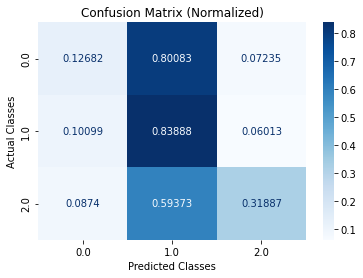

In [53]:
all_gold_labels = []
all_predicted = []

for i in y_test_all:
    for j in i:
        try:
            all_gold_labels.append(j[0])
        except:
            print(j)

for i in y_pred_test_all:
    for j in i:
        all_predicted.append(j)

overall_cm = ConfusionMatrix(all_gold_labels, all_predicted)
overall_cm.plot(cmap=plt.cm.Blues, normalized=True, number_label=True, plot_lib="seaborn")

In [66]:
overall_cm

pycm.ConfusionMatrix(classes: [0.0, 1.0, 2.0])

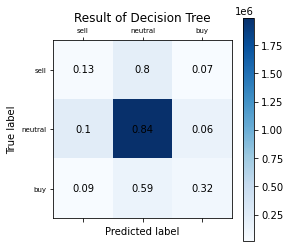

In [68]:
from sklearn.metrics import confusion_matrix

sklearn_cm = confusion_matrix(all_gold_labels, all_predicted)

CLASSES = ['sell', 'neutral', 'buy']

def plot_confusion_matrix(conf_matrix):
    conf_matrix_percentage = np.zeros(shape=(len(CLASSES), len(CLASSES)))
    for i in range(len(CLASSES)):
        for j in range(len(CLASSES)):
            conf_matrix_percentage[i][j] = conf_matrix[i][j] / np.sum(conf_matrix[i,:])
    conf_matrix_percentage = np.transpose(np.round(conf_matrix_percentage, 2))
    plt.figure(figsize=(4, 4))
    plt.matshow(conf_matrix, fignum=1, cmap=plt.cm.Blues)
    plt.colorbar()
    for x in range(len(conf_matrix_percentage)):
        for y in range(len(conf_matrix_percentage)):
            plt.annotate(conf_matrix_percentage[x, y], xy=(x, y), horizontalalignment='center', verticalalignment='center') 
    plt.title('Result of Decision Tree')    
    plt.xticks(range(len(CLASSES)),CLASSES[:len(CLASSES)],color='black',fontsize=7)
    plt.yticks(range(len(CLASSES)),CLASSES[:len(CLASSES)],color='black',fontsize=7)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
plot_confusion_matrix(sklearn_cm)

In [ ]:
overall_cm.plot(cmap=plt.cm.Blues, normalized=True, number_label=True, plot_lib="seaborn")

<AxesSubplot: title={'center': 'Confusion Matrix'}, xlabel='Predicted Classes', ylabel='Actual Classes'>

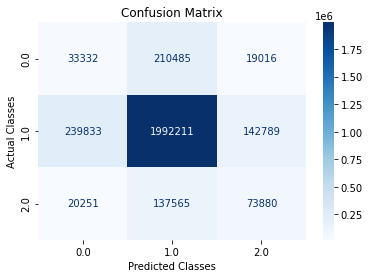

In [58]:
overall_cm.plot(cmap=plt.cm.Blues, normalized=False, number_label=True, plot_lib="seaborn")

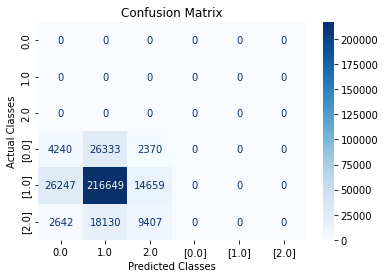

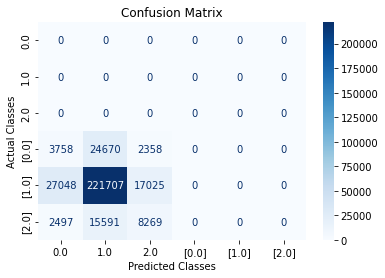

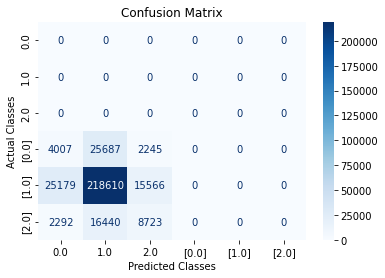

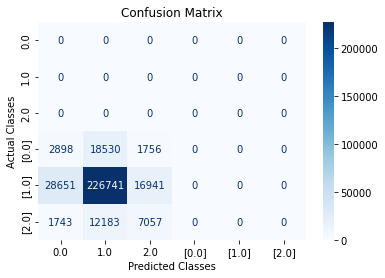

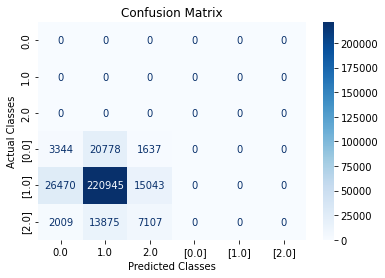

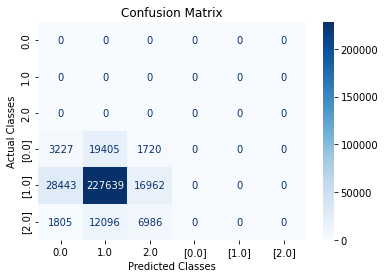

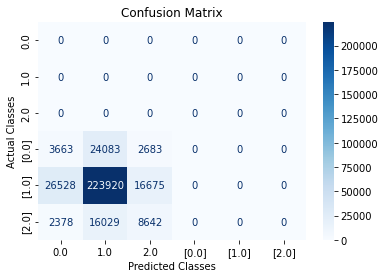

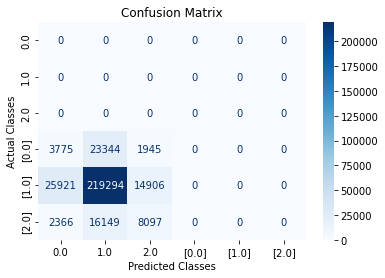

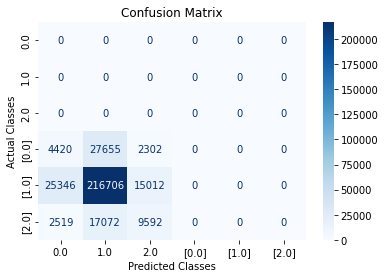

In [61]:
for i in CMs:
    i.plot(cmap=plt.cm.Blues, normalized=False, number_label=True, plot_lib="seaborn")

In [7]:
lob_profit = lob_test[lob_test['s'].notnull()]
lob_profit['Model Prediction'] = y_pred_test

In [72]:
PROFITS_UNDER_VARYING_S_CONDITIONS = []

In [78]:
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from matplotlib import pyplot
from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

def trading_algorithm(x, df):
            if x[-1] == 2:
                if df.s[x.index[-1]] <= j:
                    if df.b[x.index[0]] - df.a[x.index[-1]] > 0:
                        return df.b[x.index[0]] - df.a[x.index[-1]]
                    else:
                        return np.NaN
                else:
                    return 0
            if x[-1] == 1:
                return 0
            if x[-1] == 0:
                if df.s[x.index[-1]] <= j:
                    if df.b[x.index[-1]] - df.a[x.index[0]] > 0:
                        return df.b[x.index[-1]] - df.a[x.index[0]]
                    else:
                        return np.NaN
                else:
                    return 0

PROFITS_FOR_EACH_DAY_AS_TEST_SET = []

for i in range(len(dfs)):
    lob_test = dfs[i]
    lob_train = pd.concat(dfs[:i] + dfs[i+1:], ignore_index=True)
    print(len(lob_train), len(lob_test))

    X_train = lob_train[lob_train['s'].notnull()][['OFI10s', 'OBI', 'all_vol_diff', 's']].to_numpy()
    y_train = lob_train[lob_train['s'].notnull()]['signal_10s'].to_numpy().reshape(-1, 1)
    X_train, y_train = shuffle(X_train, y_train, random_state=1472)

    X_test = lob_test[lob_test['s'].notnull()][['OFI10s', 'OBI', 'all_vol_diff', 's']].to_numpy()
    y_test = lob_test[lob_test['s'].notnull()]['signal_10s'].to_numpy().reshape(-1, 1)

    model = DecisionTreeClassifier()
    model.fit(X_train, y_train)
    y_pred_test = model.predict(X_test)
    y_pred_train = model.predict(X_train)

    lob_profit = lob_test[lob_test['s'].notnull()]
    lob_profit['Model Prediction'] = y_pred_test
    
    PROFITS_UNDER_VARYING_S_CONDITIONS = []
    
    for j in range(1,6):

        try:
            lob_profit = lob_profit.drop(columns=['Profit'])
        except:
            pass

        lob_profit_r = lob_profit[::-1]
        lob_profit_r['Profit'] = lob_profit_r['Model Prediction'].rolling('10s').apply(lambda x: trading_algorithm(x, lob_profit_r))
        lob_profit = lob_profit.join(lob_profit_r['Profit'])

        profit = lob_profit['Profit'].sum()
        sell_inv_mean = lob_profit.b[np.logical_and(lob_profit['Profit'].isnull(), lob_profit['Model Prediction'] == 0)].mean()
        sell_inv_count = lob_profit.b[np.logical_and(lob_profit['Profit'].isnull(), lob_profit['Model Prediction'] == 0)].count()
        buy_inv_mean = lob_profit.a[np.logical_and(lob_profit['Profit'].isnull(), lob_profit['Model Prediction'] == 2)].mean()
        buy_inv_count = lob_profit.a[np.logical_and(lob_profit['Profit'].isnull(), lob_profit['Model Prediction'] == 2)].count()
        net_inv_loss = (buy_inv_mean - sell_inv_mean) * min(buy_inv_count, sell_inv_count)
        day_avg_bid_price = lob_profit.b.mean()
        day_avg_ask_price = lob_profit.a.mean()
        if buy_inv_count > sell_inv_count:
            inv_loss_rem_at_day_avg = (buy_inv_mean-day_avg_bid_price)*(buy_inv_count-sell_inv_count)
        else:
            inv_loss_rem_at_day_avg = (day_avg_ask_price-sell_inv_mean)*(sell_inv_count-buy_inv_count)
        TOTAL_PROFIT = profit - net_inv_loss - inv_loss_rem_at_day_avg

        PROFITS_UNDER_VARYING_S_CONDITIONS.append(TOTAL_PROFIT)
        
        print(f'Day {i+1} s <= {j}\nDirect Trading Profit from correct predictions:',profit,"\nSell Inventory:",sell_inv_count,"at Avg Price",sell_inv_mean,"\nBuy Inventory:",buy_inv_count,"at Avg Price",buy_inv_mean,"\nNet Inventory Loss:",net_inv_loss,"\nDay Average Bid Price:",day_avg_bid_price,"\nLoss on remaining inventory if sold at day average:",inv_loss_rem_at_day_avg,"\nOVERALL DAY PROFIT:",TOTAL_PROFIT)
    
    PROFITS_FOR_EACH_DAY_AS_TEST_SET.append(PROFITS_UNDER_VARYING_S_CONDITIONS)

2549579 320766


C:\Users\Morg\AppData\Local\Temp\ipykernel_14768\1916913422.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lob_profit['Model Prediction'] = y_pred_test
C:\Users\Morg\AppData\Local\Temp\ipykernel_14768\1916913422.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lob_profit_r['Profit'] = lob_profit_r['Model Prediction'].rolling('10s').apply(lambda x: trading_algorithm(x, lob_profit_r))


Day 1 s <= 1
Direct Trading Profit from correct predictions: 16956.0 
Sell Inventory: 1526 at Avg Price 105.84207077326343 
Buy Inventory: 3302 at Avg Price 107.8267716535433 
Net Inventory Loss: 3028.6535433070876 
Day Average Bid Price: 105.51159266177493 
Loss on remaining inventory if sold at day average: 4111.757889380638 
OVERALL DAY PROFIT: 9815.588567312276


C:\Users\Morg\AppData\Local\Temp\ipykernel_14768\1916913422.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lob_profit_r['Profit'] = lob_profit_r['Model Prediction'].rolling('10s').apply(lambda x: trading_algorithm(x, lob_profit_r))


Day 1 s <= 2
Direct Trading Profit from correct predictions: 28903.0 
Sell Inventory: 2731 at Avg Price 105.72281215671914 
Buy Inventory: 5857 at Avg Price 108.03909851459791 
Net Inventory Loss: 6325.778043366911 
Day Average Bid Price: 105.51159266177493 
Loss on remaining inventory if sold at day average: 7900.983295924646 
OVERALL DAY PROFIT: 14676.238660708445


C:\Users\Morg\AppData\Local\Temp\ipykernel_14768\1916913422.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lob_profit_r['Profit'] = lob_profit_r['Model Prediction'].rolling('10s').apply(lambda x: trading_algorithm(x, lob_profit_r))


Day 1 s <= 3
Direct Trading Profit from correct predictions: 35879.0 
Sell Inventory: 3768 at Avg Price 105.59129511677283 
Buy Inventory: 7531 at Avg Price 108.2420661266764 
Net Inventory Loss: 9988.105165316685 
Day Average Bid Price: 105.51159266177493 
Loss on remaining inventory if sold at day average: 10274.771648424266 
OVERALL DAY PROFIT: 15616.123186259047


C:\Users\Morg\AppData\Local\Temp\ipykernel_14768\1916913422.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lob_profit_r['Profit'] = lob_profit_r['Model Prediction'].rolling('10s').apply(lambda x: trading_algorithm(x, lob_profit_r))


Day 1 s <= 4
Direct Trading Profit from correct predictions: 41225.0 
Sell Inventory: 4527 at Avg Price 105.49878506737353 
Buy Inventory: 8559 at Avg Price 108.36195817268373 
Net Inventory Loss: 12961.584647739257 
Day Average Bid Price: 105.51159266177493 
Loss on remaining inventory if sold at day average: 11492.673739984288 
OVERALL DAY PROFIT: 16770.741612276455


C:\Users\Morg\AppData\Local\Temp\ipykernel_14768\1916913422.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lob_profit_r['Profit'] = lob_profit_r['Model Prediction'].rolling('10s').apply(lambda x: trading_algorithm(x, lob_profit_r))


Day 1 s <= 5
Direct Trading Profit from correct predictions: 45063.0 
Sell Inventory: 5258 at Avg Price 105.494484594903 
Buy Inventory: 9222 at Avg Price 108.44556495337237 
Net Inventory Loss: 15516.780524831942 
Day Average Bid Price: 105.51159266177493 
Loss on remaining inventory if sold at day average: 11630.26616389226 
OVERALL DAY PROFIT: 17915.9533112758
2547303 323042


C:\Users\Morg\AppData\Local\Temp\ipykernel_14768\1916913422.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lob_profit['Model Prediction'] = y_pred_test
C:\Users\Morg\AppData\Local\Temp\ipykernel_14768\1916913422.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lob_profit_r['Profit'] = lob_profit_r['Model Prediction'].rolling('10s').apply(lambda x: trading_algorithm(x, lob_profit_r))


Day 2 s <= 1
Direct Trading Profit from correct predictions: 14168.0 
Sell Inventory: 1702 at Avg Price 106.1063454759107 
Buy Inventory: 3896 at Avg Price 107.86190965092402 
Net Inventory Loss: 2987.9702258726693 
Day Average Bid Price: 105.39042434264515 
Loss on remaining inventory if sold at day average: 5422.438766363845 
OVERALL DAY PROFIT: 5757.591007763486


C:\Users\Morg\AppData\Local\Temp\ipykernel_14768\1916913422.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lob_profit_r['Profit'] = lob_profit_r['Model Prediction'].rolling('10s').apply(lambda x: trading_algorithm(x, lob_profit_r))


Day 2 s <= 2
Direct Trading Profit from correct predictions: 24030.0 
Sell Inventory: 3174 at Avg Price 105.98676748582231 
Buy Inventory: 6851 at Avg Price 108.18931542840461 
Net Inventory Loss: 6990.887169756218 
Day Average Bid Price: 105.39042434264515 
Loss on remaining inventory if sold at day average: 10291.522522337551 
OVERALL DAY PROFIT: 6747.590307906232


C:\Users\Morg\AppData\Local\Temp\ipykernel_14768\1916913422.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lob_profit_r['Profit'] = lob_profit_r['Model Prediction'].rolling('10s').apply(lambda x: trading_algorithm(x, lob_profit_r))


Day 2 s <= 3
Direct Trading Profit from correct predictions: 30158.0 
Sell Inventory: 4272 at Avg Price 106.0187265917603 
Buy Inventory: 8856 at Avg Price 108.32870370370371 
Net Inventory Loss: 9868.222222222252 
Day Average Bid Price: 105.39042434264515 
Loss on remaining inventory if sold at day average: 13469.072591092448 
OVERALL DAY PROFIT: 6820.7051866853


C:\Users\Morg\AppData\Local\Temp\ipykernel_14768\1916913422.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lob_profit_r['Profit'] = lob_profit_r['Model Prediction'].rolling('10s').apply(lambda x: trading_algorithm(x, lob_profit_r))


Day 2 s <= 4
Direct Trading Profit from correct predictions: 34691.0 
Sell Inventory: 5000 at Avg Price 105.9294 
Buy Inventory: 10089 at Avg Price 108.43730795916345 
Net Inventory Loss: 12539.539795817234 
Day Average Bid Price: 105.39042434264515 
Loss on remaining inventory if sold at day average: 15505.590724461632 
OVERALL DAY PROFIT: 6645.869479721136


C:\Users\Morg\AppData\Local\Temp\ipykernel_14768\1916913422.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lob_profit_r['Profit'] = lob_profit_r['Model Prediction'].rolling('10s').apply(lambda x: trading_algorithm(x, lob_profit_r))


Day 2 s <= 5
Direct Trading Profit from correct predictions: 38495.0 
Sell Inventory: 5715 at Avg Price 105.80909886264217 
Buy Inventory: 10926 at Avg Price 108.4966135822808 
Net Inventory Loss: 15359.14662273476 
Day Average Bid Price: 105.39042434264515 
Loss on remaining inventory if sold at day average: 16186.352127741393 
OVERALL DAY PROFIT: 6949.501249523848
2551478 318867


C:\Users\Morg\AppData\Local\Temp\ipykernel_14768\1916913422.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lob_profit['Model Prediction'] = y_pred_test
C:\Users\Morg\AppData\Local\Temp\ipykernel_14768\1916913422.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lob_profit_r['Profit'] = lob_profit_r['Model Prediction'].rolling('10s').apply(lambda x: trading_algorithm(x, lob_profit_r))


Day 3 s <= 1
Direct Trading Profit from correct predictions: 14965.0 
Sell Inventory: 1422 at Avg Price 105.74964838255977 
Buy Inventory: 3735 at Avg Price 107.99036144578314 
Net Inventory Loss: 3186.2939759036285 
Day Average Bid Price: 105.22506423549564 
Loss on remaining inventory if sold at day average: 6396.132447394987 
OVERALL DAY PROFIT: 5382.573576701384


C:\Users\Morg\AppData\Local\Temp\ipykernel_14768\1916913422.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lob_profit_r['Profit'] = lob_profit_r['Model Prediction'].rolling('10s').apply(lambda x: trading_algorithm(x, lob_profit_r))


Day 3 s <= 2
Direct Trading Profit from correct predictions: 25242.0 
Sell Inventory: 2420 at Avg Price 105.79214876033058 
Buy Inventory: 6052 at Avg Price 108.12376074025116 
Net Inventory Loss: 5642.5009914078055 
Day Average Bid Price: 105.22506423549564 
Loss on remaining inventory if sold at day average: 10528.065705272049 
OVERALL DAY PROFIT: 9071.433303320147


C:\Users\Morg\AppData\Local\Temp\ipykernel_14768\1916913422.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lob_profit_r['Profit'] = lob_profit_r['Model Prediction'].rolling('10s').apply(lambda x: trading_algorithm(x, lob_profit_r))


Day 3 s <= 3
Direct Trading Profit from correct predictions: 32104.0 
Sell Inventory: 3310 at Avg Price 105.75468277945619 
Buy Inventory: 7713 at Avg Price 108.23505769480099 
Net Inventory Loss: 8210.040969791276 
Day Average Bid Price: 105.22506423549564 
Loss on remaining inventory if sold at day average: 13253.001201321451 
OVERALL DAY PROFIT: 10640.957828887273


C:\Users\Morg\AppData\Local\Temp\ipykernel_14768\1916913422.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lob_profit_r['Profit'] = lob_profit_r['Model Prediction'].rolling('10s').apply(lambda x: trading_algorithm(x, lob_profit_r))


Day 3 s <= 4
Direct Trading Profit from correct predictions: 36703.0 
Sell Inventory: 4013 at Avg Price 105.700722651383 
Buy Inventory: 8850 at Avg Price 108.3722033898305 
Net Inventory Loss: 10720.652203389815 
Day Average Bid Price: 105.22506423549564 
Loss on remaining inventory if sold at day average: 15222.712089517747 
OVERALL DAY PROFIT: 10759.635707092439


C:\Users\Morg\AppData\Local\Temp\ipykernel_14768\1916913422.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lob_profit_r['Profit'] = lob_profit_r['Model Prediction'].rolling('10s').apply(lambda x: trading_algorithm(x, lob_profit_r))


Day 3 s <= 5
Direct Trading Profit from correct predictions: 40608.0 
Sell Inventory: 4701 at Avg Price 105.60391406083812 
Buy Inventory: 9414 at Avg Price 108.4396643297217 
Net Inventory Loss: 13330.862014021674 
Day Average Bid Price: 105.22506423549564 
Loss on remaining inventory if sold at day average: 15150.410244087407 
OVERALL DAY PROFIT: 12126.72774189092
2553760 316585


C:\Users\Morg\AppData\Local\Temp\ipykernel_14768\1916913422.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lob_profit['Model Prediction'] = y_pred_test
C:\Users\Morg\AppData\Local\Temp\ipykernel_14768\1916913422.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lob_profit_r['Profit'] = lob_profit_r['Model Prediction'].rolling('10s').apply(lambda x: trading_algorithm(x, lob_profit_r))


Day 4 s <= 1
Direct Trading Profit from correct predictions: 13446.0 
Sell Inventory: 1591 at Avg Price 105.35700817096166 
Buy Inventory: 3772 at Avg Price 107.6474019088017 
Net Inventory Loss: 3644.0164369034947 
Day Average Bid Price: 105.07206951026856 
Loss on remaining inventory if sold at day average: 5616.799961200767 
OVERALL DAY PROFIT: 4185.183601895739


C:\Users\Morg\AppData\Local\Temp\ipykernel_14768\1916913422.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lob_profit_r['Profit'] = lob_profit_r['Model Prediction'].rolling('10s').apply(lambda x: trading_algorithm(x, lob_profit_r))


Day 4 s <= 2
Direct Trading Profit from correct predictions: 20608.0 
Sell Inventory: 2834 at Avg Price 105.25829216654904 
Buy Inventory: 6642 at Avg Price 107.82520325203252 
Net Inventory Loss: 7274.62601626019 
Day Average Bid Price: 105.07206951026856 
Loss on remaining inventory if sold at day average: 10483.933288637161 
OVERALL DAY PROFIT: 2849.4406951026485


C:\Users\Morg\AppData\Local\Temp\ipykernel_14768\1916913422.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lob_profit_r['Profit'] = lob_profit_r['Model Prediction'].rolling('10s').apply(lambda x: trading_algorithm(x, lob_profit_r))


Day 4 s <= 3
Direct Trading Profit from correct predictions: 25343.0 
Sell Inventory: 3813 at Avg Price 105.21977445580907 
Buy Inventory: 8350 at Avg Price 107.98574850299401 
Net Inventory Loss: 10546.659041916177 
Day Average Bid Price: 105.07206951026856 
Loss on remaining inventory if sold at day average: 13219.361589995371 
OVERALL DAY PROFIT: 1576.9793680884522


C:\Users\Morg\AppData\Local\Temp\ipykernel_14768\1916913422.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lob_profit_r['Profit'] = lob_profit_r['Model Prediction'].rolling('10s').apply(lambda x: trading_algorithm(x, lob_profit_r))


Day 4 s <= 4
Direct Trading Profit from correct predictions: 28829.0 
Sell Inventory: 4636 at Avg Price 105.17428817946505 
Buy Inventory: 9471 at Avg Price 108.12585788195544 
Net Inventory Loss: 13683.477140745441 
Day Average Bid Price: 105.07206951026856 
Loss on remaining inventory if sold at day average: 14765.066777106054 
OVERALL DAY PROFIT: 380.4560821485047


C:\Users\Morg\AppData\Local\Temp\ipykernel_14768\1916913422.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lob_profit_r['Profit'] = lob_profit_r['Model Prediction'].rolling('10s').apply(lambda x: trading_algorithm(x, lob_profit_r))


Day 4 s <= 5
Direct Trading Profit from correct predictions: 31178.0 
Sell Inventory: 5353 at Avg Price 105.1496357182888 
Buy Inventory: 10224 at Avg Price 108.28922143974961 
Net Inventory Loss: 16806.202366979684 
Day Average Bid Price: 105.07206951026856 
Loss on remaining inventory if sold at day average: 15670.747048502184 
OVERALL DAY PROFIT: -1298.9494154818676
2558926 311419


C:\Users\Morg\AppData\Local\Temp\ipykernel_14768\1916913422.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lob_profit['Model Prediction'] = y_pred_test
C:\Users\Morg\AppData\Local\Temp\ipykernel_14768\1916913422.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lob_profit_r['Profit'] = lob_profit_r['Model Prediction'].rolling('10s').apply(lambda x: trading_algorithm(x, lob_profit_r))


Day 5 s <= 1
Direct Trading Profit from correct predictions: 13160.0 
Sell Inventory: 1529 at Avg Price 104.74493132766514 
Buy Inventory: 3021 at Avg Price 106.87520688513737 
Net Inventory Loss: 3257.1913273750415 
Day Average Bid Price: 104.38405503714557 
Loss on remaining inventory if sold at day average: 3716.798557203768 
OVERALL DAY PROFIT: 6186.010115421191


C:\Users\Morg\AppData\Local\Temp\ipykernel_14768\1916913422.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lob_profit_r['Profit'] = lob_profit_r['Model Prediction'].rolling('10s').apply(lambda x: trading_algorithm(x, lob_profit_r))


Day 5 s <= 2
Direct Trading Profit from correct predictions: 21767.0 
Sell Inventory: 2670 at Avg Price 104.53483146067416 
Buy Inventory: 5501 at Avg Price 106.99800036357026 
Net Inventory Loss: 6576.660970732589 
Day Average Bid Price: 104.38405503714557 
Loss on remaining inventory if sold at day average: 7400.07921910828 
OVERALL DAY PROFIT: 7790.259810159132


C:\Users\Morg\AppData\Local\Temp\ipykernel_14768\1916913422.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lob_profit_r['Profit'] = lob_profit_r['Model Prediction'].rolling('10s').apply(lambda x: trading_algorithm(x, lob_profit_r))


Day 5 s <= 3
Direct Trading Profit from correct predictions: 26964.0 
Sell Inventory: 3660 at Avg Price 104.45327868852459 
Buy Inventory: 7060 at Avg Price 107.10042492917847 
Net Inventory Loss: 9688.555240793208 
Day Average Bid Price: 104.38405503714557 
Loss on remaining inventory if sold at day average: 9235.657632911863 
OVERALL DAY PROFIT: 8039.787126294928


C:\Users\Morg\AppData\Local\Temp\ipykernel_14768\1916913422.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lob_profit_r['Profit'] = lob_profit_r['Model Prediction'].rolling('10s').apply(lambda x: trading_algorithm(x, lob_profit_r))


Day 5 s <= 4
Direct Trading Profit from correct predictions: 29538.0 
Sell Inventory: 4505 at Avg Price 104.42286348501665 
Buy Inventory: 8115 at Avg Price 107.2124460874923 
Net Inventory Loss: 12567.069624152791 
Day Average Bid Price: 104.38405503714557 
Loss on remaining inventory if sold at day average: 10210.491691751673 
OVERALL DAY PROFIT: 6760.438684095536


C:\Users\Morg\AppData\Local\Temp\ipykernel_14768\1916913422.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lob_profit_r['Profit'] = lob_profit_r['Model Prediction'].rolling('10s').apply(lambda x: trading_algorithm(x, lob_profit_r))


Day 5 s <= 5
Direct Trading Profit from correct predictions: 31875.0 
Sell Inventory: 5192 at Avg Price 104.44587827426811 
Buy Inventory: 8812 at Avg Price 107.3354516568316 
Net Inventory Loss: 15002.665002269607 
Day Average Bid Price: 104.38405503714557 
Loss on remaining inventory if sold at day average: 10684.0557632634 
OVERALL DAY PROFIT: 6188.279234466994
2551987 318358


C:\Users\Morg\AppData\Local\Temp\ipykernel_14768\1916913422.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lob_profit['Model Prediction'] = y_pred_test
C:\Users\Morg\AppData\Local\Temp\ipykernel_14768\1916913422.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lob_profit_r['Profit'] = lob_profit_r['Model Prediction'].rolling('10s').apply(lambda x: trading_algorithm(x, lob_profit_r))


Day 6 s <= 1
Direct Trading Profit from correct predictions: 12354.0 
Sell Inventory: 1533 at Avg Price 104.42791911285062 
Buy Inventory: 3721 at Avg Price 106.27089492072024 
Net Inventory Loss: 2825.281913464129 
Day Average Bid Price: 104.04205062790032 
Loss on remaining inventory if sold at day average: 4876.711312689973 
OVERALL DAY PROFIT: 4652.006773845898


C:\Users\Morg\AppData\Local\Temp\ipykernel_14768\1916913422.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lob_profit_r['Profit'] = lob_profit_r['Model Prediction'].rolling('10s').apply(lambda x: trading_algorithm(x, lob_profit_r))


Day 6 s <= 2
Direct Trading Profit from correct predictions: 20056.0 
Sell Inventory: 3004 at Avg Price 104.28961384820239 
Buy Inventory: 6700 at Avg Price 106.51776119402984 
Net Inventory Loss: 6693.3546268656655 
Day Average Bid Price: 104.04205062790032 
Loss on remaining inventory if sold at day average: 9150.226252414712 
OVERALL DAY PROFIT: 4212.419120719624


C:\Users\Morg\AppData\Local\Temp\ipykernel_14768\1916913422.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lob_profit_r['Profit'] = lob_profit_r['Model Prediction'].rolling('10s').apply(lambda x: trading_algorithm(x, lob_profit_r))


Day 6 s <= 3
Direct Trading Profit from correct predictions: 24524.0 
Sell Inventory: 4101 at Avg Price 104.23969763472324 
Buy Inventory: 8589 at Avg Price 106.73792059611131 
Net Inventory Loss: 10245.21236465246 
Day Average Bid Price: 104.04205062790032 
Loss on remaining inventory if sold at day average: 12099.064417330901 
OVERALL DAY PROFIT: 2179.7232180166393


C:\Users\Morg\AppData\Local\Temp\ipykernel_14768\1916913422.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lob_profit_r['Profit'] = lob_profit_r['Model Prediction'].rolling('10s').apply(lambda x: trading_algorithm(x, lob_profit_r))


Day 6 s <= 4
Direct Trading Profit from correct predictions: 27501.0 
Sell Inventory: 4938 at Avg Price 104.26225192385581 
Buy Inventory: 9797 at Avg Price 106.9066040624681 
Net Inventory Loss: 13057.810860467493 
Day Average Bid Price: 104.04205062790032 
Loss on remaining inventory if sold at day average: 13918.865138564852 
OVERALL DAY PROFIT: 524.3240009676556


C:\Users\Morg\AppData\Local\Temp\ipykernel_14768\1916913422.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lob_profit_r['Profit'] = lob_profit_r['Model Prediction'].rolling('10s').apply(lambda x: trading_algorithm(x, lob_profit_r))


Day 6 s <= 5
Direct Trading Profit from correct predictions: 30283.0 
Sell Inventory: 5655 at Avg Price 104.2526967285588 
Buy Inventory: 10475 at Avg Price 107.04143198090692 
Net Inventory Loss: 15770.297852028609 
Day Average Bid Price: 104.04205062790032 
Loss on remaining inventory if sold at day average: 14457.018121491801 
OVERALL DAY PROFIT: 55.6840264795901
2545650 324695


C:\Users\Morg\AppData\Local\Temp\ipykernel_14768\1916913422.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lob_profit['Model Prediction'] = y_pred_test
C:\Users\Morg\AppData\Local\Temp\ipykernel_14768\1916913422.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lob_profit_r['Profit'] = lob_profit_r['Model Prediction'].rolling('10s').apply(lambda x: trading_algorithm(x, lob_profit_r))


Day 7 s <= 1
Direct Trading Profit from correct predictions: 15903.0 
Sell Inventory: 1501 at Avg Price 105.16189207195204 
Buy Inventory: 3912 at Avg Price 107.1937627811861 
Net Inventory Loss: 3049.837934560318 
Day Average Bid Price: 104.59366422161361 
Loss on remaining inventory if sold at day average: 6268.837627129266 
OVERALL DAY PROFIT: 6584.324438310417


C:\Users\Morg\AppData\Local\Temp\ipykernel_14768\1916913422.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lob_profit_r['Profit'] = lob_profit_r['Model Prediction'].rolling('10s').apply(lambda x: trading_algorithm(x, lob_profit_r))


Day 7 s <= 2
Direct Trading Profit from correct predictions: 27276.0 
Sell Inventory: 2700 at Avg Price 104.99555555555555 
Buy Inventory: 6803 at Avg Price 107.49830956930766 
Net Inventory Loss: 6757.435837130697 
Day Average Bid Price: 104.59366422161361 
Loss on remaining inventory if sold at day average: 11917.759861588716 
OVERALL DAY PROFIT: 8600.804301280588


C:\Users\Morg\AppData\Local\Temp\ipykernel_14768\1916913422.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lob_profit_r['Profit'] = lob_profit_r['Model Prediction'].rolling('10s').apply(lambda x: trading_algorithm(x, lob_profit_r))


Day 7 s <= 3
Direct Trading Profit from correct predictions: 34137.0 
Sell Inventory: 3802 at Avg Price 104.89715938979485 
Buy Inventory: 8826 at Avg Price 107.67912984364378 
Net Inventory Loss: 10577.051665533623 
Day Average Bid Price: 104.59366422161361 
Loss on remaining inventory if sold at day average: 15501.379285079576 
OVERALL DAY PROFIT: 8058.569049386799


C:\Users\Morg\AppData\Local\Temp\ipykernel_14768\1916913422.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lob_profit_r['Profit'] = lob_profit_r['Model Prediction'].rolling('10s').apply(lambda x: trading_algorithm(x, lob_profit_r))


Day 7 s <= 4
Direct Trading Profit from correct predictions: 39041.0 
Sell Inventory: 4651 at Avg Price 104.80541818963664 
Buy Inventory: 10048 at Avg Price 107.76751592356688 
Net Inventory Loss: 13776.716560509527 
Day Average Bid Price: 104.59366422161361 
Loss on remaining inventory if sold at day average: 17129.277635441787 
OVERALL DAY PROFIT: 8135.005804048684


C:\Users\Morg\AppData\Local\Temp\ipykernel_14768\1916913422.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lob_profit_r['Profit'] = lob_profit_r['Model Prediction'].rolling('10s').apply(lambda x: trading_algorithm(x, lob_profit_r))


Day 7 s <= 5
Direct Trading Profit from correct predictions: 42419.0 
Sell Inventory: 5319 at Avg Price 104.74976499341982 
Buy Inventory: 10774 at Avg Price 107.88230926304065 
Net Inventory Loss: 16662.002970113233 
Day Average Bid Price: 104.59366422161361 
Loss on remaining inventory if sold at day average: 17939.558700984533 
OVERALL DAY PROFIT: 7817.4383289022335
2554431 315914


C:\Users\Morg\AppData\Local\Temp\ipykernel_14768\1916913422.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lob_profit['Model Prediction'] = y_pred_test
C:\Users\Morg\AppData\Local\Temp\ipykernel_14768\1916913422.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lob_profit_r['Profit'] = lob_profit_r['Model Prediction'].rolling('10s').apply(lambda x: trading_algorithm(x, lob_profit_r))


Day 8 s <= 1
Direct Trading Profit from correct predictions: 13830.0 
Sell Inventory: 1522 at Avg Price 104.67411300919842 
Buy Inventory: 3554 at Avg Price 106.97411367473269 
Net Inventory Loss: 3500.6010129431593 
Day Average Bid Price: 104.11967498107961 
Loss on remaining inventory if sold at day average: 5800.219425503058 
OVERALL DAY PROFIT: 4529.179561553782


C:\Users\Morg\AppData\Local\Temp\ipykernel_14768\1916913422.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lob_profit_r['Profit'] = lob_profit_r['Model Prediction'].rolling('10s').apply(lambda x: trading_algorithm(x, lob_profit_r))


Day 8 s <= 2
Direct Trading Profit from correct predictions: 22972.0 
Sell Inventory: 2793 at Avg Price 104.53884711779449 
Buy Inventory: 6027 at Avg Price 107.0474531275925 
Net Inventory Loss: 7006.536585365857 
Day Average Bid Price: 104.11967498107961 
Loss on remaining inventory if sold at day average: 9468.434525822695 
OVERALL DAY PROFIT: 6497.028888811448


C:\Users\Morg\AppData\Local\Temp\ipykernel_14768\1916913422.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lob_profit_r['Profit'] = lob_profit_r['Model Prediction'].rolling('10s').apply(lambda x: trading_algorithm(x, lob_profit_r))


Day 8 s <= 3
Direct Trading Profit from correct predictions: 28767.0 
Sell Inventory: 3990 at Avg Price 104.58671679197995 
Buy Inventory: 7527 at Avg Price 107.24657898233028 
Net Inventory Loss: 10612.850139497794 
Day Average Bid Price: 104.11967498107961 
Loss on remaining inventory if sold at day average: 11059.859452423601 
OVERALL DAY PROFIT: 7094.290408078605


C:\Users\Morg\AppData\Local\Temp\ipykernel_14768\1916913422.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lob_profit_r['Profit'] = lob_profit_r['Model Prediction'].rolling('10s').apply(lambda x: trading_algorithm(x, lob_profit_r))


Day 8 s <= 4
Direct Trading Profit from correct predictions: 32867.0 
Sell Inventory: 4769 at Avg Price 104.52044453763892 
Buy Inventory: 8535 at Avg Price 107.4166373755126 
Net Inventory Loss: 13811.943643819533 
Day Average Bid Price: 104.11967498107961 
Loss on remaining inventory if sold at day average: 12416.360377434607 
OVERALL DAY PROFIT: 6638.69597874586


C:\Users\Morg\AppData\Local\Temp\ipykernel_14768\1916913422.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lob_profit_r['Profit'] = lob_profit_r['Model Prediction'].rolling('10s').apply(lambda x: trading_algorithm(x, lob_profit_r))


Day 8 s <= 5
Direct Trading Profit from correct predictions: 36084.0 
Sell Inventory: 5453 at Avg Price 104.47625160462131 
Buy Inventory: 9131 at Avg Price 107.48746030007666 
Net Inventory Loss: 16420.121016318033 
Day Average Bid Price: 104.11967498107961 
Loss on remaining inventory if sold at day average: 12386.714403271151 
OVERALL DAY PROFIT: 7277.164580410816
2549646 320699


C:\Users\Morg\AppData\Local\Temp\ipykernel_14768\1916913422.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lob_profit['Model Prediction'] = y_pred_test
C:\Users\Morg\AppData\Local\Temp\ipykernel_14768\1916913422.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lob_profit_r['Profit'] = lob_profit_r['Model Prediction'].rolling('10s').apply(lambda x: trading_algorithm(x, lob_profit_r))


Day 9 s <= 1
Direct Trading Profit from correct predictions: 16298.0 
Sell Inventory: 1481 at Avg Price 104.8953409858204 
Buy Inventory: 3213 at Avg Price 107.38375350140056 
Net Inventory Loss: 3685.338935574225 
Day Average Bid Price: 104.45542130345825 
Loss on remaining inventory if sold at day average: 5071.871366836082 
OVERALL DAY PROFIT: 7540.789697589692


C:\Users\Morg\AppData\Local\Temp\ipykernel_14768\1916913422.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lob_profit_r['Profit'] = lob_profit_r['Model Prediction'].rolling('10s').apply(lambda x: trading_algorithm(x, lob_profit_r))


Day 9 s <= 2
Direct Trading Profit from correct predictions: 28010.0 
Sell Inventory: 2794 at Avg Price 104.79885468861846 
Buy Inventory: 5717 at Avg Price 107.5042854644044 
Net Inventory Loss: 7558.973587545922 
Day Average Bid Price: 104.45542130345825 
Loss on remaining inventory if sold at day average: 8911.829942445604 
OVERALL DAY PROFIT: 11539.196470008474


C:\Users\Morg\AppData\Local\Temp\ipykernel_14768\1916913422.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lob_profit_r['Profit'] = lob_profit_r['Model Prediction'].rolling('10s').apply(lambda x: trading_algorithm(x, lob_profit_r))


Day 9 s <= 3
Direct Trading Profit from correct predictions: 36146.0 
Sell Inventory: 3835 at Avg Price 104.68318122555411 
Buy Inventory: 7357 at Avg Price 107.60799238820171 
Net Inventory Loss: 11216.650808753548 
Day Average Bid Price: 104.45542130345825 
Loss on remaining inventory if sold at day average: 11103.355360466454 
OVERALL DAY PROFIT: 13825.993830779998


C:\Users\Morg\AppData\Local\Temp\ipykernel_14768\1916913422.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lob_profit_r['Profit'] = lob_profit_r['Model Prediction'].rolling('10s').apply(lambda x: trading_algorithm(x, lob_profit_r))


Day 9 s <= 4
Direct Trading Profit from correct predictions: 40892.0 
Sell Inventory: 4607 at Avg Price 104.62470154113306 
Buy Inventory: 8409 at Avg Price 107.76287311214175 
Net Inventory Loss: 14457.556427637006 
Day Average Bid Price: 104.45542130345825 
Loss on remaining inventory if sold at day average: 12574.93177661465 
OVERALL DAY PROFIT: 13859.511795748344


C:\Users\Morg\AppData\Local\Temp\ipykernel_14768\1916913422.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lob_profit_r['Profit'] = lob_profit_r['Model Prediction'].rolling('10s').apply(lambda x: trading_algorithm(x, lob_profit_r))


Day 9 s <= 5
Direct Trading Profit from correct predictions: 45261.0 
Sell Inventory: 5368 at Avg Price 104.72149776453055 
Buy Inventory: 9057 at Avg Price 107.84189025063486 
Net Inventory Loss: 16750.266865407924 
Day Average Bid Price: 104.45542130345825 
Loss on remaining inventory if sold at day average: 12492.683946134513 
OVERALL DAY PROFIT: 16018.049188457562


In [79]:
PROFITS_FOR_EACH_DAY_AS_TEST_SET

[[9815.588567312276,
  14676.238660708445,
  15616.123186259047,
  16770.741612276455,
  17915.9533112758],
 [5757.591007763486,
  6747.590307906232,
  6820.7051866853,
  6645.869479721136,
  6949.501249523848],
 [5382.573576701384,
  9071.433303320147,
  10640.957828887273,
  10759.635707092439,
  12126.72774189092],
 [4185.183601895739,
  2849.4406951026485,
  1576.9793680884522,
  380.4560821485047,
  -1298.9494154818676],
 [6186.010115421191,
  7790.259810159132,
  8039.787126294928,
  6760.438684095536,
  6188.279234466994],
 [4652.006773845898,
  4212.419120719624,
  2179.7232180166393,
  524.3240009676556,
  55.6840264795901],
 [6584.324438310417,
  8600.804301280588,
  8058.569049386799,
  8135.005804048684,
  7817.4383289022335],
 [4529.179561553782,
  6497.028888811448,
  7094.290408078605,
  6638.69597874586,
  7277.164580410816],
 [7540.789697589692,
  11539.196470008474,
  13825.993830779998,
  13859.511795748344,
  16018.049188457562]]

In [82]:
decision_tree_model_profits = pd.DataFrame(PROFITS_FOR_EACH_DAY_AS_TEST_SET, index=dates, columns=['s=1','s=2','s=3','s=4','s=5'])
decision_tree_model_profits

,s=1,s=2,s=3,s=4,s=5
2024-06-10,9815.588567,14676.238661,15616.123186,16770.741612,17915.953311
2024-06-11,5757.591008,6747.590308,6820.705187,6645.869480,6949.501250
2024-06-12,5382.573577,9071.433303,10640.957829,10759.635707,12126.727742
2024-06-13,4185.183602,2849.440695,1576.979368,380.456082,-1298.949415
2024-06-14,6186.010115,7790.259810,8039.787126,6760.438684,6188.279234
2024-06-17,4652.006774,4212.419121,2179.723218,524.324001,55.684026
2024-06-18,6584.324438,8600.804301,8058.569049,8135.005804,7817.438329
2024-06-19,4529.179562,6497.028889,7094.290408,6638.695979,7277.164580
2024-06-21,7540.789698,11539.196470,13825.993831,13859.511796,16018.049188


In [84]:
decision_tree_model_profits.describe()

,s=1,s=2,s=3,s=4,s=5
count,9.000000,9.000000,9.000000,9.000000,9.000000
mean,6070.360816,7998.267951,8205.903245,7830.519905,8116.649805
std,1766.994715,3594.308968,4688.916516,5452.082202,6461.878367
min,4185.183602,2849.440695,1576.979368,380.456082,-1298.949415
25%,4652.006774,6497.028889,6820.705187,6638.695979,6188.279234
50%,5757.591008,7790.259810,8039.787126,6760.438684,7277.164580
75%,6584.324438,9071.433303,10640.957829,10759.635707,12126.727742
max,9815.588567,14676.238661,15616.123186,16770.741612,17915.953311


In [86]:
decision_tree_model_profits.loc['Total',:] = decision_tree_model_profits.sum()

In [87]:
decision_tree_model_profits

,s=1,s=2,s=3,s=4,s=5
2024-06-10,9815.588567,14676.238661,15616.123186,16770.741612,17915.953311
2024-06-11,5757.591008,6747.590308,6820.705187,6645.869480,6949.501250
2024-06-12,5382.573577,9071.433303,10640.957829,10759.635707,12126.727742
2024-06-13,4185.183602,2849.440695,1576.979368,380.456082,-1298.949415
2024-06-14,6186.010115,7790.259810,8039.787126,6760.438684,6188.279234
2024-06-17,4652.006774,4212.419121,2179.723218,524.324001,55.684026
2024-06-18,6584.324438,8600.804301,8058.569049,8135.005804,7817.438329
2024-06-19,4529.179562,6497.028889,7094.290408,6638.695979,7277.164580
2024-06-21,7540.789698,11539.196470,13825.993831,13859.511796,16018.049188
Total,54633.247340,71984.411558,73853.129202,70474.679145,73049.848246


In [89]:
decision_tree_model_profits.to_csv('decision_tree_model_profits.csv')

Exampe of how results are calculated with above model and algorithm for s <= 4:
 - £27,418 from completed trades (resulting from correct predictions)
 - Net inventory loss of £12,910.14
 - Remaining positive inventory 4,915 at an average price of £106.91 against a day average bid price of £104.04.
 - RESULTS: Net profit of £14,507.86 with positive inventory of 4,915 units with average price £106.91. If sold at the day average bid, total profit = £401.81 for the day**
 
**RESULTS: When varied for different levels of the minimum spread required to make a trade using day 6 as test order book day:**
 - s <= 1: £4,512.49
 - s <= 2: £4,034.12
 - s <= 3: £2,006.66
 - s <= 4: £408.68
 - s <= 5: £25.80